# South Korea -- SIR like models

This notebook contains all the Julia 1.4.x code required to characterize the 
propagation of CoViD19 as discussed in the main notebook:
 _Population_dynamics.ipynb_

Here we use _SIR_ like models, that characterize the spread of CoViD19 by
accommodating decay mechanism which account for recovery and death.

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV
using Dates

using Optim, DifferentialEquations, DiffEqParamEstim


using Plots

theme( :gruvbox_light );
mysize = ( Int( round( 400 *MathConstants.golden ) ), 400 );


# load my functions
using MyFunctions, Mrate

### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6;      # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2;   # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ );
β0 = βΓ( μΓ, σΓ );

ρ0=[α0,β0];

### load data and manipulate data

In [3]:
path = pwd()*"/datahub.io/covid-19/data";
path_data = path*"/time-series-19-covid-combined.csv";
path_ref  = path*"/reference.csv";

raw_data = CSV.File( path_data ) |> DataFrame!;
col_names = names( raw_data )

col_names[2] = "CountryRegion";
col_names[3] = "ProvinceState";
rename!( raw_data, col_names );

In [4]:
country_names =  unique( raw_data[!,2] );
country_name = "Korea, South";
country = raw_data |> @filter( _.CountryRegion==country_name
    ) |> DataFrame;

In [5]:
dates = Date.( country[!,:Date] );

confirmed_int = convert( Array{Number}, country[!,:Confirmed] );
recovered_int = convert( Array{Number}, country[!,:Recovered] );
deaths_int    = convert( Array{Number}, country[!,:Deaths   ] );

In [6]:
d1   = findfirst( >=(1  ), confirmed_int );
d10  = findfirst( >=(10 ), confirmed_int );
d20  = findfirst( >=(20 ), confirmed_int );
d50  = findfirst( >=(50 ), confirmed_int );
d100 = findfirst( >=(100), confirmed_int );

read raw data and basic processing

In [7]:
raw_ref  = CSV.File( path_ref  ) |> DataFrame!;
ref_names = names( raw_ref )

IDs = convert( Vector, raw_ref[!,11] );

row_country = findall( isequal( country_name ), IDs );
country_name = "Korea_South"; # much easier to work with this!

@assert length( row_country ) == 1
population = convert.( Number, raw_ref[ row_country[1], 12 ] );

println( [ population, 1/population ]' )

[5.1269183e7 1.9504894392407227e-8]


In [8]:
#   set initial time and offset it to day of first registered infection
date_1 = dates[ d1 ]
data_last = dates[ end ]
days = float.( Dates.value.( dates -date_1 ) )

# normalize population
confirmed = confirmed_int ./ population;
recovered = recovered_int ./ population;
deaths    = deaths_int    ./ population;

# determine normalized sir time series
removed     = ( recovered +deaths  );
infected    = ( confirmed -removed );
susceptible = ( 1 .-infected .-removed );

#### visualize raw data

In [9]:
nM = 1.25 *maximum( confirmed )
nm = 0.75 *minimum( confirmed )


tm, tM = days[d1], maximum( days ) +5;

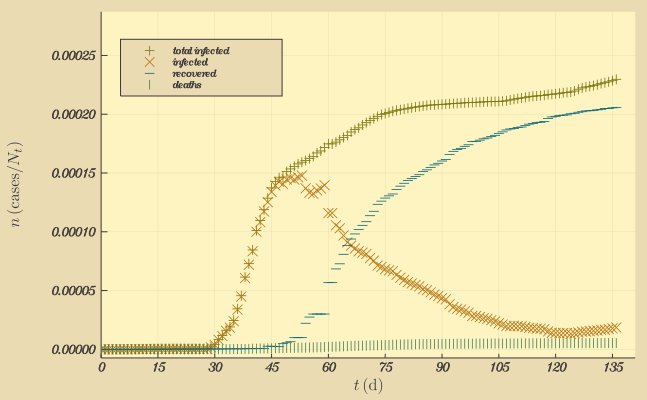

In [10]:
plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( days, infected, label="infected"
    , markershape=:xcross, markersize=5, linealpha=0 )
plot!( days, recovered, label="recovered"
    , markershape=:hline, markersize=5, linealpha=0 )
plot!( days, deaths, label="deaths"
    , markershape=:vline, markersize=5, linealpha=0 )

### SIR-like models

#### Susceptible, infected and removed

In [11]:
# ------------------------------------ #
#
#   SIR-like model is available from Mrate.jl
#   
#   sir_Γ! ≡ differential equation with respect to:,
#            1 -susceptible
#            infected
#            removed
#   
#   sidr_Γ! ≡ differential equation with respect to:,
#            1 -susceptible
#            infected
#            recovered
#            deceased


# ------------------------------------ #
# 
#   initialization values and test run
#
du0 = zeros(3); u0 = [ 1e-7, 1e-7, 0. ]; t0 = 1.0;

p0 = [ 0.26, 0.01, 34.9 ]; νμ0 = 1/21.0; ρ0 = [ 6.25, 0.96 ];

println( sir_Γ!(du0,u0,t0; p=p0, ν=νμ0, ρ=ρ0) )

# ------------------------------------ #
# 
# the Optim.optimize routine requires an optimization function that takes a
# single entry of parameters p, to facilitate this we define 
# 
function SIR!( du,u,p,t )
    sir_Γ!( du,u,t; p=p[1:end-1], ν=p[end], ρ=ρ0)
end

append!( p0, νμ0 )
println( SIR!( du0,u0,p0,1.0 ) )

4.761904761904761e-9
4.761904761904761e-9


In [12]:
# ------------------------------------ #
# 
#   make an unified data array
#
data_0 = zeros(3,length(infected))
data_0[1,:] = 1.0 .-susceptible
data_0[2,:] = 1.0 .*infected
data_0[3,:] = 1.0 .*removed

#   initialization values and test run
#
d_ini = d20
d_end = length(infected)
data = data_0[:,d_ini:d_end]
days_t = days[d_ini:d_end]

u0 = data[:,1]
tspan = (days_t[1],days_t[end] )
du0 = similar( u0 )


p1 = [ 0.26, 0.01, 34.9 ]; append!( p1, νμ0 )
p2 = [ 0.26, 0.01, 34.9, 0.00183, 66.4 ]; append!( p2, νμ0 )
p3 = [ 0.26, 0.01, 34.9, 0.00183, 66.4, 0.02, 105]; append!( p3, νμ0 )

p0 = p3; println( round.( p0; sigdigits=3 ) )

[0.26, 0.01, 34.9, 0.00183, 66.4, 0.02, 105.0, 0.0476]


##### Define the differential equation problem, optimize and solve it with optimal parameters

In [13]:
#   define the ODE problem and cost function using:
#       DifferentialEquations.jl
#       DiffEqParamEstim.jl
#
prob = ODEProblem(SIR!,u0,tspan,p0)

cost = build_loss_objective( prob, Tsit5(), L2Loss(days_t,data),
    abstol = 1e-12, reltol = 1e-12, verbose = false)

println( "\np0 and minimizers for prob_0 and prob" )
println( round.( p0; sigdigits=3 ) )


p0 and minimizers for prob_0 and prob
[0.26, 0.01, 34.9, 0.00183, 66.4, 0.02, 105.0, 0.0476]


In [14]:
#   optimize parameters via Optim.jl with different algorithms

result_0 = Optim.optimize( cost, p0, NelderMead() )
println( string( round.( result_0.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( result_0 ) )  )

result   = Optim.optimize( cost, p0, BFGS() )
println( string( round.( result.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( result ) )  )

[0.249, 0.0254, 35.2, 0.0162, 65.3, 0.0317, 111.0, 0.0427] Converged: true
[0.244, 0.0238, 34.9, 0.000582, 66.4, 0.0229, 105.0, 0.0331] Converged: true


In [15]:
#   integrate the differential equations with optimal parameters
#
prob_opt_0 = ODEProblem( SIR!, u0, tspan, result_0.minimizer, saveat=1 );
sol_opt_0 = solve(prob_opt_0,Tsit5());
prob_opt = ODEProblem( SIR!, u0, tspan, result.minimizer, saveat=1 );
sol_opt = solve(prob_opt,Tsit5());

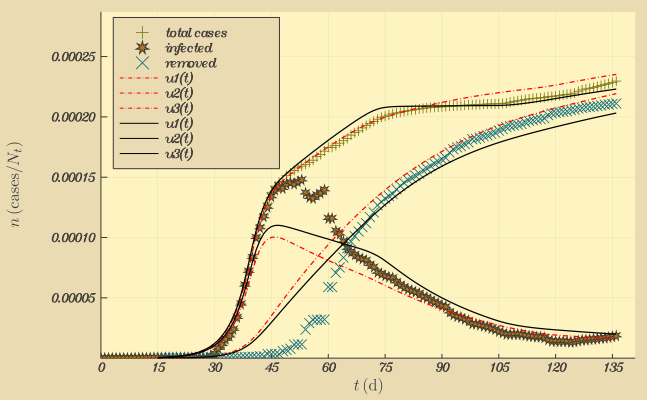

In [16]:
plot(days,confirmed,label="total cases", shape=:cross, msize=5, lα=0)
plot!(days,infected,label="infected", shape=:star7 , msize=5, lα=0)
plot!(days,removed ,label="removed" , shape=:xcross, msize=5, lα=0)

plot!( sol_opt_0, style=:dashdot, lcolor=:red, width=1.25 ) # NelderMead()
plot!( sol_opt, lcolor=:black, width=1.25 ) # BFGS()

plot!( xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (nm,nM)
    , legend=(.12,.94), size=mysize )

In [17]:
savefig("img/"*country_name*"_SIR.svg")


println( round.( result_0.minimum; sigdigits=5 ) )
println( round.( result.minimum; sigdigits=5 ) )

# the active and death mean lifetimes \tau_i = 1/\nu_i
println( round.( 1 ./ result_0.minimizer[end]; sigdigits=3 ) )
println( round.( 1 ./ result.minimizer[end]; sigdigits=3 ) )

9.7917e-8
5.8822e-8
23.4
30.2


#### Susceptible, infected, recovered and deceased

In [18]:
du0 = zeros(4); u0 = [ 1e-7, 1e-7, 0., 0. ]; t0 = 1.0;

p0 = [ 0.26, 0.01, 34.9 ]; νμ0 = [ 1/21.0, 0.5/21 ]; ρ0 = [ 6.25, 0.96 ];

println( sird_Γ!(du0,u0,t0; p=p0, νμ=νμ0, ρ=ρ0) )

function SIRD!( du,u,p,t )
    sird_Γ!( du,u,t; p=p[1:end-2], νμ=p[end-1:end], ρ=ρ0)
end
append!( p0, νμ0 )
println( SIRD!( du0,u0,p0,t0 ) )

2.3809523809523806e-9
2.3809523809523806e-9


In [19]:
# ------------------------------------ #
# 
#   make an unified data array
#
data_0 = zeros(4,length(infected))
data_0[1,:] = 1.0 .-susceptible
data_0[2,:] = 1.0 .*infected
data_0[3,:] = 1.0 .*recovered
data_0[4,:] = 1.0 .*deaths

#   initialization values and test run
#
#
d_ini = d20
d_end = length(infected)
# d_end = t_break_1 -1
data = data_0[:,d_ini:d_end]
days_t = days[d_ini:d_end]

u0 = data[:,1]
tspan = (days_t[1],days_t[end] )
du0 = similar( u0 )


τr =21; rr = 1/τr
νμ0 = [ rr, rr/10 ]
# τr =29; rr = 1/τr

p3 = [ 0.26, 0.02, 45, 0.005, 75, 0.01, 105]; append!( p3, νμ0 )

p0 = p3; println( round.( p0; sigdigits=3 ) )

[0.26, 0.02, 45.0, 0.005, 75.0, 0.01, 105.0, 0.0476, 0.00476]


##### Define the differential equation problem, optimize and solve it with optimal parameters

In [20]:
prob = ODEProblem(SIRD!,u0,tspan,p0);

cost = build_loss_objective( prob  , Tsit5(), L2Loss(days_t,data),
    abstol = 1e-16, reltol = 1e-16, verbose = true);

println( "\np0 and minimizers for prob_0 and prob" )
println( round.( p0; sigdigits=3 ) )


p0 and minimizers for prob_0 and prob
[0.26, 0.02, 45.0, 0.005, 75.0, 0.01, 105.0, 0.0476, 0.00476]


In [21]:
res0 = Optim.optimize(cost, p0, NelderMead() )
println( string( round.( res0.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( res0 ) )  )
prob_opt_0 = ODEProblem( SIRD!, u0, tspan, res0.minimizer, saveat=1 );
sol_opt_0  = solve(prob_opt_0,Tsit5());

res1 = Optim.optimize(cost, p0, BFGS() )
println( string( round.( res1.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( res1 ) )  )
prob_opt_1 = ODEProblem( SIRD!, u0, tspan, res1.minimizer, saveat=1 );
sol_opt_1  = solve(prob_opt_1,Tsit5());

[0.218, 0.0192, 39.2, 0.00201, 77.0, 0.0139, 169.0, 0.0379, -0.00217] Converged: true
[0.229, 0.0146, 37.7, 1.93e-5, 74.9, 0.0231, 105.0, 0.0326, 0.000568] Converged: true


In [22]:
#   slow and reduces to results from BFGS
# 
# res2 = Optim.optimize(cost, p0, GradientDescent(),
#     Optim.Options( iterations = 10000, show_trace=true, show_every=250 ) )
# println( string( round.( res2.minimizer; sigdigits=3 )
#     )*" Converged: "*string( Optim.converged( res2 ) )  )
# prob_opt_2 = ODEProblem( SIRD!, u0, tspan, res2.minimizer, saveat=1 );
# sol_opt_2  = solve(prob_opt_2,Tsit5());

In [23]:
# constrained BFGS

lower = [1e-6, 1e-6, 20, 1e-6, 50, 1e-6, 100, 0., 0.];
upper = [1e+0, 1e+0, 50, 1e+0, 80, 1e+0, 130, 1., 1.];

res3 = Optim.optimize(cost, lower, upper, p0, Fminbox( BFGS( ) ) )
println( string( round.( res3.minimizer; sigdigits=3 )
    )*" Converged: "*string( Optim.converged( res3 ) )  );

prob_opt_3 = ODEProblem( SIRD!, u0, tspan, res3.minimizer, saveat=1 );
sol_opt_3  = solve(prob_opt_3,Tsit5());

[0.245, 0.0237, 34.8, 0.00173, 65.8, 0.0398, 114.0, 0.0321, 0.000555] Converged: true


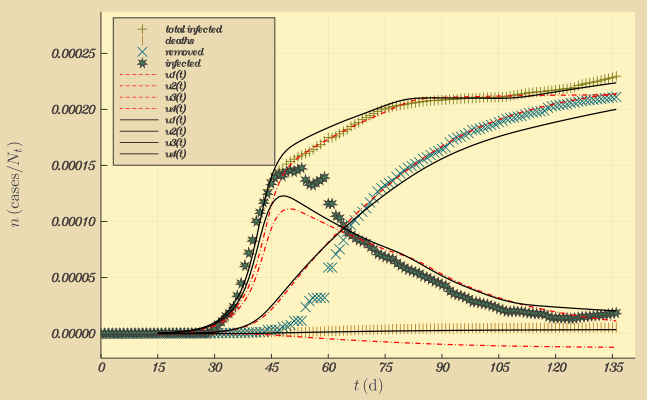

In [24]:
plot(days,confirmed,label="total infected",shape=:cross,msize=5,lα=0)
plot!(days,deaths  ,label="deaths"  ,shape=:vline ,msize=5,lα=0)
plot!(days,removed ,label="removed" ,shape=:xcross,msize=5,lα=0)
plot!(days,infected,label="infected",shape=:star7 ,msize=5,lα=0)


plot!( sol_opt_0, style=:dashdot, lcolor=:red, width=1.25 ) # NelderMead()
plot!( sol_opt_1, lcolor=:black, width=1.25 ) # BFGS()
# plot!( sol_opt_2, lcolor=:green, width=1.25 )
# plot!( sol_opt_3, lcolor=:blue, width=1.25 )


plot!( xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-1500*nm,nM)
    , legend=(.12,.95), legendfontsize=6, size=mysize )

In [25]:
savefig("img/"*country_name*"_SIRD.svg")


println( round.( res0.minimum; sigdigits=5 ) )
println( round.( res1.minimum; sigdigits=5 ) )

# the active and death mean lifetimes \tau_i = 1/\nu_i
println( round.( 1 ./ res0.minimizer[end-1:end]; sigdigits=3 ) )
println( round.( 1 ./ res1.minimizer[end-1:end]; sigdigits=3 ) )

9.0319e-8
5.1052e-8
[26.4, -461.0]
[30.6, 1760.0]
